In [60]:
# https://blog.keras.io/building-autoencoders-in-keras.html

In [61]:
'''
this one is simple auto encoder, without padding
'''

'\nthis one is simple auto encoder, without padding\n'

In [62]:
from google.colab import drive
import os

In [63]:

drive.mount('/content/gdrive')

root_path = r'gdrive/My Drive/work/research/AutoEncoder_classification/UTKFace/'  #change dir to your project folder

os.chdir(root_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


FileNotFoundError: ignored

In [79]:
from tensorflow.keras.datasets import mnist

import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense, Cropping2D
from tensorflow.keras.layers import Flatten, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [80]:
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split


### 01 Get the data

In [81]:
# X=np.array(pickle.load(open("pickles/X_resized_grayed.p","rb")))
X=np.array(pickle.load(open("pickles/X_grayed_resized50.p","rb")))

In [82]:
y_genders=np.array(pickle.load(open("pickles/y_genders.p","rb")))
y_ages=np.array(pickle.load(open("pickles/y_ages.p","rb")))

In [83]:
X_adults=[]
y_genders_adults=[]
for i in range(len(X)):
    if y_ages[i]>18 and y_ages[i]<60:
        X_adults.append(X[i])
        y_genders_adults.append(y_genders[i])
X_adults=np.array(X_adults)
y_genders_adults=np.array(y_genders_adults)
X_adults=X_adults.reshape(len(X_adults),100,100,1)


In [84]:
# lim=1000
# X=X[:]
# y_genders=y_genders[:]
# X=X.reshape(len(X),34,34,1)

In [85]:
x_train, x_test, y_train, y_test = train_test_split(X_adults, y_genders_adults, test_size=0.33,random_state=42)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# x_train=x_train.reshape(len(x_train),34,34,1)
# x_test=x_test.reshape(len(x_test),34,34,1)

print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(2828, 100, 100, 1) (2828,)
(1394, 100, 100, 1) (1394,)


In [86]:
autoenc_epochs=50
cnn_epochs=40

### 02 Create and train the model

In [87]:
# input_img = keras.Input(shape=x_train[0].shape)

# x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
# x = layers.MaxPooling2D((2, 2), padding='same')(x)
# x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# x = layers.MaxPooling2D((2, 2), padding='same')(x)
# x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# # at this point the representation is (4, 4, 8) i.e. 128-dimensional

# x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
# x = layers.UpSampling2D((2, 2))(x)

# x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# x = layers.UpSampling2D((2, 2))(x)
# x = Cropping2D(cropping=((1, 1), (1, 1)), data_format=None)(x) # this is the added step
# x = layers.Conv2D(16, (3, 3), activation='relu',padding='same')(x)
# x = layers.UpSampling2D((2, 2))(x)
# decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# autoencoder = keras.Model(input_img, decoded)
# autoencoder.compile(optimizer='adam', loss='mse')

In [89]:
input_img = keras.Input(shape=x_train[0].shape)

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)


# at this point the representation is (4, 4, 8) i.e. 128-dimensional


x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
# x = Cropping2D(cropping=((1, 1), (1, 1)), data_format=None)(x) # this is the added step
x = layers.Conv2D(16, (3, 3), activation='relu',padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)

decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [90]:
autoencoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
conv2d_141 (Conv2D)          (None, 100, 100, 16)      160       
_________________________________________________________________
max_pooling2d_129 (MaxPoolin (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_142 (Conv2D)          (None, 50, 50, 8)         1160      
_________________________________________________________________
max_pooling2d_130 (MaxPoolin (None, 25, 25, 8)         0         
_________________________________________________________________
conv2d_143 (Conv2D)          (None, 25, 25, 8)         584       
_________________________________________________________________
up_sampling2d_9 (UpSampling2 (None, 50, 50, 8)         0   

In [91]:
history=autoencoder.fit(x_train, x_train,
                epochs=200,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test, x_test))


Epoch 1/200
45/45 [==============================] - 2s 26ms/step - loss: 0.0443 - val_loss: 0.0103
Epoch 2/200
45/45 [==============================] - 1s 22ms/step - loss: 0.0075 - val_loss: 0.0053
Epoch 3/200
45/45 [==============================] - 1s 22ms/step - loss: 0.0050 - val_loss: 0.0042
Epoch 4/200
45/45 [==============================] - 1s 22ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 5/200
45/45 [==============================] - 1s 22ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 6/200
45/45 [==============================] - 1s 22ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 7/200
45/45 [==============================] - 1s 22ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 8/200
45/45 [==============================] - 1s 22ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 9/200
45/45 [==============================] - 1s 22ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 10/200
45/45 [==============================] - 1s 22ms/step - loss: 0.0021 - val_loss: 0.0020

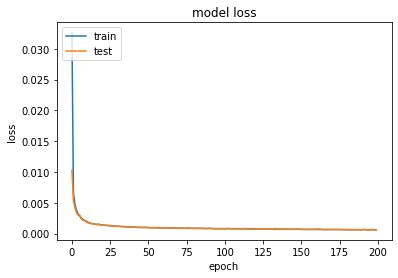

In [92]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

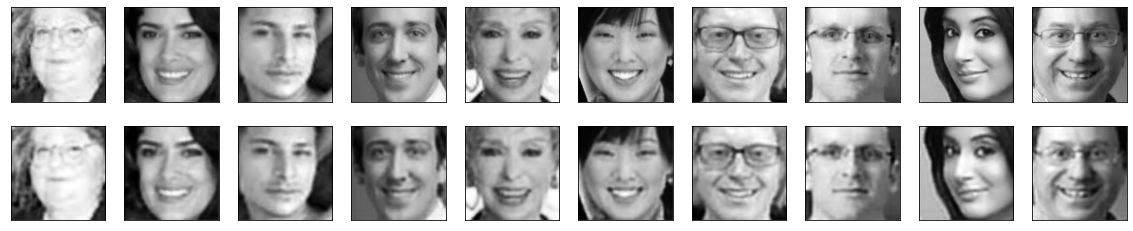

In [93]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(100,100))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(100,100))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


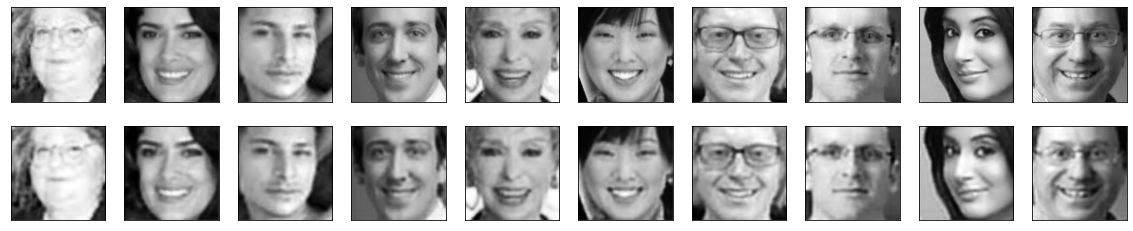

In [94]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(100,100))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(100,100))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [95]:
autoencoder.save("models/autoenc_simple.h")

INFO:tensorflow:Assets written to: models/autoenc_simple.h/assets


In [96]:
y_test[0]

1

#### 02a Save the encoder part

In [97]:
encoder = Model(inputs=input_img, outputs=encoded)
encoder.save('models/encoder_simple.h5')

### 03 Test encoded images with a LogReg

In [98]:
def flatten_encoded_images_for_logreg(X_array):
    print(X_array.shape)
    X_array_flattened=[]
    for i in range(X_array.shape[0]):
        X_array_flattened.append(X_array[i].flatten())
    X_array_flattened=np.array(X_array_flattened)
    print("Shape is ",X_array_flattened.shape)
    return X_array_flattened

In [99]:
# load the model from file
encoder = load_model('models/encoder_simple.h5')
# encode the train data
x_train_encode = encoder.predict(x_train)
x_train_encode_flat=flatten_encoded_images_for_logreg(x_train_encode)

# x_train_encode=x_train_encode.flatten()
print("Shape of encoded flat",x_train_encode_flat.shape)
# encode the test data
x_test_encode = encoder.predict(x_test)
x_test_encode_flat=flatten_encoded_images_for_logreg(x_test_encode)
print("Shape of encoded flat",x_test_encode_flat.shape)



(2828, 25, 25, 8)
Shape is  (2828, 5000)
Shape of encoded flat (2828, 5000)
(1394, 25, 25, 8)
Shape is  (1394, 5000)
Shape of encoded flat (1394, 5000)


In [100]:
# define the model
model = LogisticRegression()
# fit the model on the training set
model.fit(x_train_encode_flat, y_train)
# make predictions on the test set
yhat = model.predict(x_test_encode_flat)
# calculate classification accuracy
acc = accuracy_score(y_test, yhat)
print(acc)

0.9311334289813487


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### 04 Test encoded images with a CNN

In [101]:
# https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5

#### 04a Convert y values to categorical

In [102]:
#one-hot encode target column
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
print(y_train_one_hot.shape,y_test_one_hot.shape)

(2828, 2) (1394, 2)


#### 04b Extract features using encoder

In [103]:
# load the model from file
encoder = load_model('models/encoder_simple.h5')
# encode the train data
x_train_encode = encoder.predict(x_train)
print("Shape of training encoded images",x_train_encode.shape)

# encode the test data
x_test_encode = encoder.predict(x_test)
print("Shape of testing encoded images",x_test_encode.shape)


Shape of training encoded images (2828, 25, 25, 8)
Shape of testing encoded images (1394, 25, 25, 8)


In [104]:
print(x_train_encode[0].shape,x_test_encode[1].shape)

(25, 25, 8) (25, 25, 8)


### 04c create a CNN that takes encoded image as input

In [105]:
def get_model(x_train):
    # define a CNN to make the predictions
    #create model
    model = Sequential()#add model layers
    model.add(Conv2D(24, kernel_size=5, padding="same", activation='relu', input_shape=x_train[0].shape))
    model.add(MaxPool2D())
    model.add(Conv2D(48, kernel_size=5, padding="same", activation='relu'))
    model.add(MaxPool2D())
    model.add(Conv2D(64, kernel_size=5, padding="same", activation='relu'))
    model.add(MaxPool2D(padding='same'))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    #compile model using accuracy to measure model performance
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])    
    return model
    

In [106]:
acc_list=[]
for i in range(20):
    model=get_model(x_train_encode)
    # print(model.summary())
    #train the model
    num_epochs=40
    history=model.fit(x_train_encode, y_train_one_hot, validation_data=(x_test_encode, y_test_one_hot), epochs=num_epochs,verbose=0)
    loss,acc=model.evaluate(x_test_encode, y_test_one_hot)
    print("Accuracy is ",acc)
    acc_list.append(acc)


44/44 [==============================] - 0s 3ms/step - loss: 0.4469 - accuracy: 0.9326
Accuracy is  0.9325681328773499
44/44 [==============================] - 0s 3ms/step - loss: 0.3235 - accuracy: 0.9240
Accuracy is  0.9239598512649536
44/44 [==============================] - 0s 3ms/step - loss: 0.4926 - accuracy: 0.9254
Accuracy is  0.9253945350646973
44/44 [==============================] - 0s 3ms/step - loss: 0.4230 - accuracy: 0.9283
Accuracy is  0.9282639622688293
44/44 [==============================] - 0s 3ms/step - loss: 0.3774 - accuracy: 0.9326
Accuracy is  0.9325681328773499
44/44 [==============================] - 0s 3ms/step - loss: 0.3831 - accuracy: 0.9326
Accuracy is  0.9325681328773499
44/44 [==============================] - 0s 3ms/step - loss: 0.3394 - accuracy: 0.9297
Accuracy is  0.9296987056732178
44/44 [==============================] - 0s 3ms/step - loss: 0.3152 - accuracy: 0.9319
Accuracy is  0.931850790977478
44/44 [==============================] - 0s 3ms/s

In [107]:
print(sum(acc_list)/len(acc_list))



0.9284433245658874


In [57]:
# 0.8368723034858704


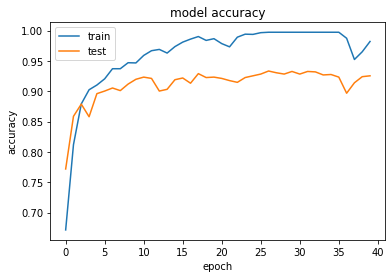

In [58]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()